# Let's try to identify ptcda simulations on different corrugations

In [1]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)



def rotate_image(image_array, angle, reshape=True, mode='nearest'):
    """
    Rotate a given numpy array image by the specified angle.

    Parameters:
    - image_array (numpy.ndarray): The input image array.
    - angle (float): The rotation angle in degrees.
    - reshape (bool): If True, the output shape will change. If False, the output shape is the same as the input.
    - mode (str): The mode parameter determines how the input array is extended when the filter overlaps a border.

    Returns:
    - numpy.ndarray: The rotated image array.
    """
    return rotate(image_array, angle, reshape=reshape, mode=mode)
def load_jmol(path, dimension=[224,224], zoom=1):
    jmol_image = Image.open(path)

    # Determine the aspect ratio by finding the shorter dimension
    width, height = jmol_image.size
    min_dim = min(width, height)

    # Calculate the left, top, right, bottom coordinates for cropping
    left = (width - min_dim) / 2
    top = (height - min_dim) / 2
    right = (width + min_dim) / 2
    bottom = (height + min_dim) / 2

    # Crop the image to square
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))

    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)

    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)

    return jmol_image_array

def run_prediction_extra(molec_path, dimension=[224,224], zoom=1, verbose=False):
    img_stack = load_img_stack(molec_path)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    first_CID = _extract_cid(output_df.iloc[0]['path'])
    second_CID = _extract_cid(output_df.iloc[1]['path'])
    tanimoto_first = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    
    gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
    first_jmol = load_jmol_image(first_CID, dimension=dimension, zoom=zoom)
    second_jmol = load_jmol_image(second_CID, dimension=dimension, zoom=zoom)

    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(f'top candidate: {first_CID} tanimoto: {tanimoto_first}')
        print(f'second candidate: {second_CID} tanimoto: {tanimoto_second}')
        print('########################')
        print(output_df.iloc[:5]['CID'])
        print('########################')
        
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, 
                       interpolation='bilinear', rotation=0, fill_pixel = (5, 5)):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = rotation
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        
        im_list[i] = TF.affine(im_list[i], 0, [0, 0], zoom, 0,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel(fill_pixel)
                                )
        
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], 1, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel(fill_pixel)
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack




def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

def run_prediction(molec_path, dimension=[224,224], zoom=1, verbose=False, zoom_jmol = None):
    img_stack = load_img_stack(molec_path, zoom=zoom)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    pred_CID = _extract_cid(output_df.iloc[0]['path'])
    tanimoto = output_df.iloc[0]['tanimoto']
    if zoom_jmol is not None:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom_jmol)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom_jmol)
    else:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom)
    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(tanimoto)
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto

def plot_images(img_1, img_3, img_5, gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].imshow(img_1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img_3, cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(img_5, cmap='gray')
    ax[2].axis('off')
    ax[3].imshow(gt_jmol)
    ax[3].axis('off')
    ax[4].imshow(pred_jmol)


    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[4].add_patch(rect)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=20)

    plt.tight_layout()
    plt.show()

In [2]:
# IMPORTS
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rdkit.Chem.AllChem as AllChem
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import pickle
#import rdkit.Chem.AllChem as AllChem
import rdkit.Chem as Chem
import sys
USER = os.getenv('USER')
sys.path.append('../../.')


# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM_with_noise, parse_val_ks

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy



print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 10
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


/tmp/ipykernel_208049/2121411961.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_208049/2121411961.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)


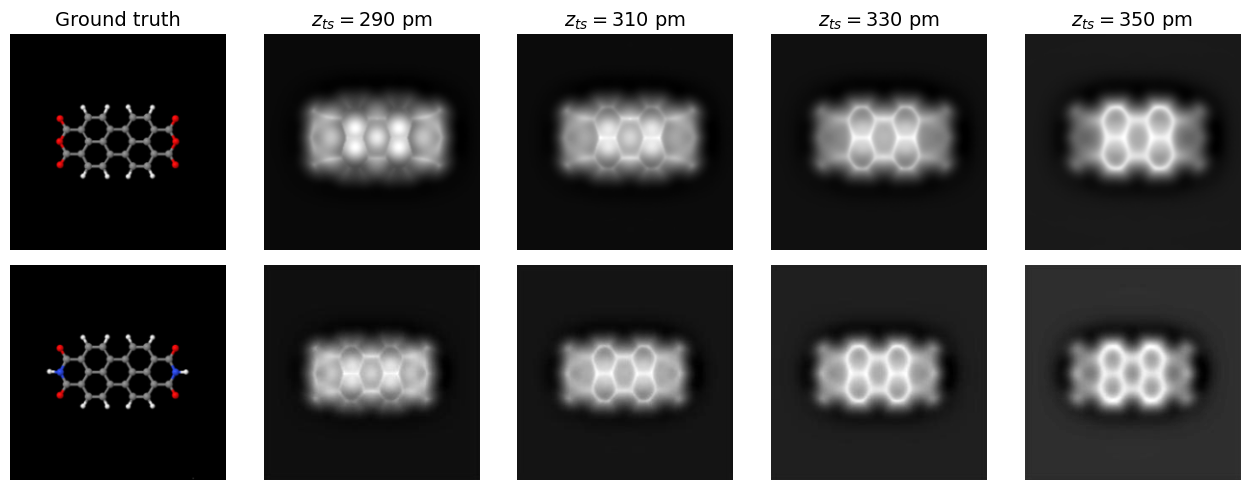

In [3]:
import matplotlib.pyplot as plt

# Assuming 'load_exp_img_stack', 'load_img_stack', and 'load_jmol_image' are defined in your context
ptcda_CID = 67191
ptcda_nh_CID = 66475

ptcda_path = '../../data/PTCDA_simulations/PTCDA_gas/K14'
ptcda_nh_path = '/scratch/dataset/quam/K-14/Conformer3D_CID_66475_K080_Amp060'

exp_img = load_exp_img_stack(ptcda_path, dimensions=[224, 224], zoom=1.2)
img_stack_nh = load_img_stack(ptcda_nh_path)

# Creating subplots
f, axarr = plt.subplots(2, 5, figsize=(13, 5))
plt.subplots_adjust(wspace=0.01, hspace=0.1)  # Adjusting layout

# Titles for each column
column_titles = ['Ground truth', '$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm',  '$z_{ts}=350$ pm']

# Displaying Jmol images in the first column
jmol_img = load_jmol_image(ptcda_CID, dimension=[224, 224], zoom=1)
axarr[0, 0].imshow(jmol_img)
axarr[0, 0].axis('off')

jmol_img_nh = load_jmol_image(ptcda_nh_CID, dimension=[224, 224], zoom=1)
axarr[1, 0].imshow(jmol_img_nh)
axarr[1, 0].axis('off')

# Displaying experimental and simulated images
for j in range(4):
    axarr[0, j+1].imshow(exp_img[j], cmap='gray')
    axarr[0, j+1].axis('off')

    axarr[1, j+1].imshow(img_stack_nh[j], cmap='gray')
    axarr[1, j+1].axis('off')

# Adding titles to each column
for ax, col_title in zip(axarr[0], column_titles):
    ax.set_title(col_title, fontsize=14)
    
plt.tight_layout()
plt.savefig('ptcda_ag_and_nh.pdf', dpi=500, format='pdf', quality=120, optimize=True)


plt.show()
